<a href="https://colab.research.google.com/github/FedericoFiorio01/pp/blob/main/Copia_di_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Installazioni con pip
!pip install --upgrade pip

# Pacchetti Python (da pip)
!pip install absl-py==2.1.0 ale-py==0.8.1 attrs==24.2.0 autorom==0.6.1 \
            autorom-accept-rom-license==0.6.1 click==8.1.7 fastjsonschema==2.20.0 \
            fsspec==2024.9.0 grpcio==1.66.1 jsonschema==4.23.0 jsonschema-specifications==2023.12.1 \
            markdown==3.7 markdown-it-py==3.0.0 mdurl==0.1.2 mpl-tools==0.4.0 \
            nbformat==5.10.4 nbstripout==0.7.1 opencv-python==4.10.0.84 protobuf==5.28.0 \
            pygame==2.6.0 referencing==0.35.1 rich==13.8.0 rpds-py==0.20.0 shimmy==1.3.0 \
            stable-baselines3==2.3.2 tensorboard==2.17.1 tensorboard-data-server==0.7.2 tqdm==4.66.5 werkzeug==3.0.4

# Installazione di pacchetti PyTorch per CPU
!pip install torch==2.4.1 torchvision==0.19.1 torchaudio==2.4.1

# Pacchetti aggiuntivi richiesti
!pip install gymnasium pandas matplotlib numpy

# Controlla le installazioni (opzionale)
!pip list


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.5 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Farama_Notifications-0.0.4-py3-none-any.whl.metadata (558 bytes)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 126.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 154.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 47.3 MB/s eta 0:00:00
Using cached Farama_Notifications-0.0.4-py3-none-any.whl (2.5 kB)
  Created wheel for autorom-accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446667 sha256=bd34bd25373ad5ca7e98703ccbab95a7f289c7bb337a62825cf42ce83

In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


# General Information

## Data:
Renewable Energy Community (REC) energy management https://doi.org/10.1016/j.dib.2022.108590

The dataset reports data of the prosumers’ (producers+consumers) energy dynamics for a period of 1 year.
The consumption related to 50 households and 1 public building is reported, separated for each consumer and for different appliances.
The energy production is reported for the entire REC, consisting in 15 photovoltaic panels.
The REC is provided with a fuel cell to store the electricity charge or to provide power, and the buying/selling to the grid happens with a different pricing depending on the time of the day.

## Task:
To develop an optimal strategy for battery management using Reinforcement Learning in order to maximize the economical reward achieved buying energy from the provider or by selling the photovoltaic-produced energy to the grid.
Data from the 1st half of the year can be used to train the predictive models, and data from the 2nd half of the year can be used to evaluate the performance.

In [ ]:
import numpy as np

# Definizione delle variabili
# Definizione dei parametri della batteria e di import/export energia
Pbmax = 9 * 0.02  # Potenza batteria massima [MW], ovvero valore massimo della azione di carica batteria
Pbmin = -9 * 0.02  # Potenza batteria minima [MW], ovvero valore minimo della azione di carica batteria (scarica massima istantanea)

Pimax = 16  # Massima potenza importabile dalla rete [MW]
Pemax = 16  # Massima potenza esportabile alla rete [MW]\

Eb = 9 * 0.3  # Capacità batteria: 9 batterie da 0.3 MWh, da considerare come un'unica batteria [MWh]
socmax = 0.9  # Limite superiore dello stato di carica della batteria [per unità]
socmin = 0.1  # Limite inferiore dello stato di carica della batteria [p.u.]

eta_ch = 0.866  # Efficienza di carica della batteria
eta_dsc = 0.866  # Efficienza di scarica della batteria


#fasce VARIABILI a cui vendo energia a Enel
f1_e = 75.83  # €/MWh
f2_e = 62.23  # €/MWh
f3_e = 51.97  # €/MWh

# €/MWh prezzo FISSO a cui compro da Enel
Ci = 0.1584 * 1000

DeltaT = 4  # Durata di un intervallo temporale

# Calcolo dei prezzi orari di vendita
infrasettimanale_e = np.concatenate([
    f3_e * np.ones(int((7 - 0) * DeltaT)),
    f2_e * np.ones(int((8 - 7) * DeltaT)),
    f1_e * np.ones(int((19 - 8) * DeltaT)),
    f2_e * np.ones(int((23 - 19) * DeltaT)),
    f3_e * np.ones(int((24 - 23) * DeltaT))
])

sabato_e = np.concatenate([
    f3_e * np.ones(int((7 - 0) * DeltaT)),
    f2_e * np.ones(int((23 - 7) * DeltaT)),
    f3_e * np.ones(int((24 - 23) * DeltaT))
])

domenica_e = f3_e * np.ones(int(24 * DeltaT))

## Fattori da tenere in considerazione per le conseguenze delle azioni scelte dall'agente:
# La batteria non può caricarsi a più di socmax*Eb, e scaricarsi a meno di socmin*Eb

In [ ]:
# Creo un df con i prezzi di vendita e di acquisto
import pandas as pd
Ce = pd.DataFrame({'1': infrasettimanale_e,
                   '2': infrasettimanale_e,
                '3': infrasettimanale_e,
                '4': infrasettimanale_e,
                '5': infrasettimanale_e,
                '6': sabato_e,
                '7': domenica_e})

In [ ]:
Ce

,1,2,3,4,5,6,7
0,51.97,51.97,51.97,51.97,51.97,51.97,51.97
1,51.97,51.97,51.97,51.97,51.97,51.97,51.97
2,51.97,51.97,51.97,51.97,51.97,51.97,51.97
3,51.97,51.97,51.97,51.97,51.97,51.97,51.97
4,51.97,51.97,51.97,51.97,51.97,51.97,51.97
...,...,...,...,...,...,...,...
91,62.23,62.23,62.23,62.23,62.23,62.23,51.97
92,51.97,51.97,51.97,51.97,51.97,51.97,51.97
93,51.97,51.97,51.97,51.97,51.97,51.97,51.97
94,51.97,51.97,51.97,51.97,51.97,51.97,51.97


In [ ]:
# Download dei dati di consumo e produzione da https://zenodo.org/records/6778401/files/Dataset.xlsx?download=1
import os
import requests
import pandas as pd

path = "data/raw"
url = 'https://zenodo.org/record/6778401/files/Dataset.xlsx?download=1'
filename = 'Dataset.xlsx'

if not os.path.exists(path):
    os.makedirs(path)

if not os.path.exists(os.path.join(path, filename)):
    r = requests.get(url)
    with open(os.path.join(path, filename), 'wb') as f:
        f.write(r.content)

# Convert for each sheet into xlsx created a csv file
xls = pd.ExcelFile(os.path.join(path, filename))
for sheet_name in xls.sheet_names:
    if not os.path.exists(os.path.join(path, sheet_name + '.csv')):
        df = pd.read_excel(xls, sheet_name)
        df.to_csv(os.path.join(path, sheet_name + '.csv'), index=False)

## Environment definition

The environment is defined by the following parameters:
- `battery_capacity`: the battery capacity in kWh
- `initial_charge`: the initial charge of the battery in kWh
- `charge_power`: the power at which the battery can be charged in kW
- `discharge_power`: the power at which the battery can be discharged in kW
- `efficiency`: the efficiency of the battery (0 < efficiency < 1)
- `buy_price`: the price of buying energy from the provider in €/kWh
- `sell_price`: the price of selling energy to the grid in €/kWh
- `consumption`: the energy consumption of the prosumers in kWh
- `production`: the energy production of the photovoltaic panels in kWh
- `state`: the state of the environment, defined by the current charge of the battery and the current hour of the day
- `action`: the action taken by the agent, defined by the power at which the battery is charged or discharged


# Objective

The objective is to train an agent using Reinforcement Learning to learn the optimal strategy for battery management, in order to maximize the economical reward achieved buying energy from the provider or by selling the photovoltaic-produced energy to the grid.


## 1. Dafinizione dell'ambiente
- Funzione di carica e scarica della batteria
- Funzione di forecast del consumo
- Funzione di calcolo del costo energetico


In [ ]:
def carica(Pb, soc):
    '''Funzione di carica della batteria
    Pb: potenza di carica della batteria [KW]
    soc: stato di carica della batteria [MWh]
    Eb: capacità della batteria [MWh]
    eta_ch: efficienza di carica della batteria
    DeltaT: durata di un intervallo temporale [h]
    socmax: limite superiore dello stato di carica della batteria [p.u.]
    '''

    # From Kw to MW
    Pb = Pb / 1000

    if Pb > Pbmax:
        Pb = Pbmax

    # Per semplicità DeltaT = 1/4 = 0.25
    # Intervallo temporale di 15 minuti
    # TODO Check if this is correct
    soc = min(soc + Pb * eta_ch * 1 / Eb, socmax)
    return soc

# Test della funzione di carica
soc = 0.5  # Stato di carica iniziale della batteria [p.u.]
print(carica(0.1, soc))

0.5000320740740741


In [ ]:
# Funzione di scarica
def scarica(Pb, soc):
    '''Funzione di scarica della batteria
    Pb: potenza di scarica della batteria [KW]
    soc: stato di carica della batteria [MWh]
    Eb: capacità della batteria [MWh]
    eta_dsc: efficienza di scarica della batteria
    DeltaT: durata di un intervallo temporale [h]
    socmin: limite inferiore dello stato di carica della batteria [p.u.]
    '''
    # From Kw to MW
    Pb = Pb / 1000

    if Pb > (Pbmin * -1):
        Pb = Pbmin*-1

    # Per semplicità DeltaT = 1/4 = 0.25
    # Intervallo temporale di 15 minuti
    # TODO Check if this is correct
    soc = max(soc - Pb * eta_dsc * 1 / Eb, socmin)
    return soc

# Test della funzione di scarica
print(scarica(0.1, soc))

0.4999679259259259


Per semplicità la funzione di forecast del consumo e produzione è implementata come funzione che restituisce il consumo e la produzione attuale, senza considerare la stagionalità o la variazione oraria.

The excel spreadsheet is comprised of the total consumption and total PV production profiles, then all the separated by appliance used and their profiles. All the data were inserted into 15-minute intervals and represent a full year (366 days).

“Total Consumers” sheet: total energy consumption profiles, in kW, of the Public building (column A) and each of the 50 residential consumers (columns B to AY) for one year (35,136 periods of 15 minutes);

“Total Producers” sheet: total PV energy Production profiles, in kW, by the Public building (column A) and each of the 14 residential producers (columns B to O) for one year (35,136 periods of 15 minutes);

In [ ]:
# Read Total Consumers csv file and print the first 5 rows
consumers = pd.read_csv(os.path.join(path, 'Total Consumers.csv'))
consumers.head()

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,2.964,2.322959,1.544607,0.778310,1.962012,2.677445,0.237877,0.689194,0.358525,0.814643,...,0.898895,0.203825,0.221624,0.319531,0.830996,0.924987,0.219128,0.274880,0.990488,0.779475
1,2.584,2.371797,1.544607,0.778310,1.962012,2.733737,0.192929,0.558967,0.358525,0.660712,...,0.917793,0.165311,0.179747,0.319531,0.848467,0.944434,0.177722,0.222940,1.011313,0.795863
2,3.071,2.415961,1.319880,0.665072,1.676555,2.784640,0.382869,1.109272,0.377198,1.311186,...,0.934883,0.328060,0.356708,0.336174,0.864266,0.962019,0.352691,0.442426,1.030144,0.810682
3,2.694,2.302538,1.319880,0.665072,1.676555,2.653908,0.442052,1.280743,0.377198,1.513868,...,0.890992,0.378772,0.411848,0.336174,0.823691,0.916855,0.407209,0.510816,0.981781,0.772623
4,2.569,2.363063,0.913154,0.460128,1.159919,2.723669,0.192242,0.556976,0.668500,0.658358,...,0.914413,0.164722,0.179106,0.595793,0.845343,0.940956,0.177089,0.222146,1.007588,0.792932


In [ ]:
# Add a 3 new columns to the consumers dataframe with the following values:
# - 'day': 1 to 7 for each day of the week
# - 'hour': 0 to 23 for each hour of the day
# - 'week': 1 to 52 for each week of the year
# Remember that the dataset starts on 2019-01-01 and
# the first day of the week is a Tuesday
# and each row is an 15-minute interval

consumers['day'] = (consumers.index // 96) % 7 + 2 # Tuesday is the first day of the week
consumers['hour'] = consumers.index % 96 // 4
consumers['week'] = (consumers.index // 96) // 7 + 1

consumers.head(100)

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,day,hour,week
0,2.964,2.322959,1.544607,0.778310,1.962012,2.677445,0.237877,0.689194,0.358525,0.814643,...,0.319531,0.830996,0.924987,0.219128,0.274880,0.990488,0.779475,2,0,1
1,2.584,2.371797,1.544607,0.778310,1.962012,2.733737,0.192929,0.558967,0.358525,0.660712,...,0.319531,0.848467,0.944434,0.177722,0.222940,1.011313,0.795863,2,0,1
2,3.071,2.415961,1.319880,0.665072,1.676555,2.784640,0.382869,1.109272,0.377198,1.311186,...,0.336174,0.864266,0.962019,0.352691,0.442426,1.030144,0.810682,2,0,1
3,2.694,2.302538,1.319880,0.665072,1.676555,2.653908,0.442052,1.280743,0.377198,1.513868,...,0.336174,0.823691,0.916855,0.407209,0.510816,0.981781,0.772623,2,0,1
4,2.569,2.363063,0.913154,0.460128,1.159919,2.723669,0.192242,0.556976,0.668500,0.658358,...,0.595793,0.845343,0.940956,0.177089,0.222146,1.007588,0.792932,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2.528,0.478050,0.150346,0.075758,0.190975,0.551001,0.455960,1.321037,1.273511,1.561496,...,1.135002,0.171014,0.190356,0.420021,0.526886,0.203836,0.160411,2,23,1
96,3.054,0.345928,0.337092,0.169857,0.428185,0.398717,0.567715,1.644821,1.702994,1.944216,...,1.517774,0.123749,0.137746,0.522967,0.656026,0.147501,0.116077,3,0,1
97,2.677,0.372131,0.337092,0.169857,0.428185,0.428919,0.465677,1.349188,1.702994,1.594772,...,1.517774,0.133123,0.148180,0.428972,0.538115,0.158673,0.124870,3,0,1
98,3.522,0.521968,0.363996,0.183413,0.462359,0.601621,0.137276,0.397726,0.440687,0.470121,...,0.392757,0.186724,0.207844,0.126456,0.158630,0.222562,0.175148,3,0,1


In [ ]:
# Save the consumers dataframe into a csv file
silver_path = "data/silver"
if not os.path.exists(silver_path):
    os.makedirs(silver_path)
consumers.to_csv(os.path.join(silver_path, 'TotalConsumption.csv'), index=False)

In [ ]:
# Read Total Consumers csv file and print the first 5 rows
producers = pd.read_csv(os.path.join(path, 'Total Producers.csv'))
producers.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Add a 3 new columns to the consumers dataframe with the following values:
# - 'day': 1 to 7 for each day of the week
# - 'hour': 0 to 23 for each hour of the day
# - 'week': 1 to 52 for each week of the year
# Remember that the dataset starts on 2019-01-01 and
# the first day of the week is a Tuesday
# and each row is an 15-minute interval

producers['day'] = (producers.index // 96) % 7 + 2 # Tuesday is the first day of the week
producers['hour'] = producers.index % 96 // 4
producers['week'] = (producers.index // 96) // 7 + 1

producers.head(100)

,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,day,hour,week
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,23,1
96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,0,1
97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,0,1
98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,0,1


In [ ]:
# Save the consumers dataframe into a csv file
silver_path = "data/silver"
if not os.path.exists(silver_path):
    os.makedirs(silver_path)
consumers.to_csv(os.path.join(silver_path, 'TotalProductions.csv'), index=False)

In [ ]:
target_window_size = 8
window_size = 16

La funzione di predizione prende in input un array di dimensione window_size e restituisce il consumo o la produzione come media dei valori nella window.


In [ ]:
def predict(window):
    '''Funzione di predizione
    window: finestra temporale contenente i consumi o le produzioni passati

    return: previsione del consumo o della produzione futura in un np.array di dimensione target_window_size
    come media dei valori della finestra temporale passata
    '''

    #check if the window has the correct size
    if len(window) != window_size:
        raise ValueError(f'window size must be {window_size}')

    prediction = np.zeros(target_window_size)
    for i in range(target_window_size):
        prediction[i] = np.mean(window)

    return prediction

# Test della funzione di predizione
print(predict(consumers['0'].values[:16]))  # 0.00010416666666666667

[2.8828125 2.8828125 2.8828125 2.8828125 2.8828125 2.8828125 2.8828125
 2.8828125]


Definiamo due funzioni che calcolano il valore dell'energia consumata e prodotta in un dato istante di tempo.

In [ ]:
def prezzo_acquisto(Pi):
    '''Funzione di calcolo del prezzo di acquisto dell'energia
    Pe: potenza importata dalla rete [MW]

    return: prezzo di acquisto dell'energia [€/MWh]
    '''

    # Calcolo del prezzo di acquisto dell'energia
    # Convert Kw to Mw
    Pi = Pi / 1000
    return Pi * Ci

# Test della funzione di calcolo del prezzo di acquisto
print(prezzo_acquisto(1))  # 158.4

0.1584


In [ ]:
def prezzo_di_vendita(day,hour,Pe):
    '''Funzione di calcolo del prezzo di vendita dell'energia
    Pe: potenza esportata alla rete [MW]

    return: prezzo di vendita dell'energia [€/MWh]
    '''

    # Calcolo del prezzo di vendita dell'energia
    hour = hour * DeltaT
    tariffa = Ce[str(day)].loc[hour]

    # Pe from Kw to Mw
    Pe = Pe / 1000
    return Pe * tariffa

# Test della funzione di calcolo del prezzo di vendita
print(prezzo_di_vendita(1,1,1))  # 77.97

0.05197


In [ ]:
def stream_data(start_idx, window_size, df):
    return df.iloc[start_idx:start_idx+window_size]

stream_data(0,window_size=10,df=consumers)

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,day,hour,week
0,2.964,2.322959,1.544607,0.778310,1.962012,2.677445,0.237877,0.689194,0.358525,0.814643,...,0.319531,0.830996,0.924987,0.219128,0.274880,0.990488,0.779475,2,0,1
1,2.584,2.371797,1.544607,0.778310,1.962012,2.733737,0.192929,0.558967,0.358525,0.660712,...,0.319531,0.848467,0.944434,0.177722,0.222940,1.011313,0.795863,2,0,1
2,3.071,2.415961,1.319880,0.665072,1.676555,2.784640,0.382869,1.109272,0.377198,1.311186,...,0.336174,0.864266,0.962019,0.352691,0.442426,1.030144,0.810682,2,0,1
3,2.694,2.302538,1.319880,0.665072,1.676555,2.653908,0.442052,1.280743,0.377198,1.513868,...,0.336174,0.823691,0.916855,0.407209,0.510816,0.981781,0.772623,2,0,1
4,2.569,2.363063,0.913154,0.460128,1.159919,2.723669,0.192242,0.556976,0.668500,0.658358,...,0.595793,0.845343,0.940956,0.177089,0.222146,1.007588,0.792932,2,1,1
5,3.174,2.334031,0.913154,0.460128,1.159919,2.690207,0.195137,0.565365,0.668500,0.668274,...,0.595793,0.834957,0.929395,0.179757,0.225492,0.995209,0.783190,2,1,1
6,2.558,2.299585,0.997031,0.502393,1.266463,2.650505,0.238003,0.689557,0.216609,0.815072,...,0.193050,0.822635,0.915679,0.219243,0.275025,0.980522,0.771632,2,1,1
7,2.922,2.316070,0.997031,0.502393,1.266463,2.669505,0.194367,0.563131,0.216609,0.665634,...,0.193050,0.828532,0.922243,0.179046,0.224601,0.987551,0.777163,2,1,1
8,2.994,2.341043,1.074578,0.541468,1.364965,2.698289,0.192219,0.556909,0.224078,0.658279,...,0.199707,0.837465,0.932187,0.177068,0.222119,0.998199,0.785543,2,2,1
9,3.223,2.402921,1.074578,0.541468,1.364965,2.769610,0.232280,0.672978,0.224078,0.795476,...,0.199707,0.859601,0.956827,0.213972,0.268413,1.024584,0.806307,2,2,1


Definiamo ora il nostro environment. Lo stato dell'environment è definito dalla carica attuale della batteria e dall'ora, dal giorno e dalla settimana.

## Stato dell'environment
Lo stato dell'environment è definito da:
- 'soc': la carica attuale della batteria
- 'history': la storia dei consumi e delle produzioni passate (window_size)
  - 'hour': l'ora
  - 'day': il giorno
  - 'week': la settimana
  - 'consumption': il consumo
  - 'production': la produzione

## Azione
L'insieme delle azioni possibili è:
- 'carica': caricare la batteria
- 'scarica': scaricare la batteria
- 'compra': comprare energia dalla rete
- 'vendi': vendere energia alla rete

## Reward
Il reward è definita come segue:
- se l'azione è vendi, la reward è il prezzo di vendita dell'energia moltiplicato per l'energia venduta
- se l'azione è compra, la reward è il prezzo di acquisto dell'energia moltiplicato per l'energia acquistata moltplicato per -10
- se la quantità di energia nella batteria più la quantità di energia aquistata è minore della quantità di energia consumata, la reward è -1000

In [ ]:
from gymnasium import Env, spaces

In [ ]:
from gymnasium.utils import seeding

class EnergyStorageEnv(Env):
    def __init__(self, consumer_id, window_size, target_window_size, seed=None, max_outages_per_episode=1):
        self.consumer_id = consumer_id
        self.window_size = window_size
        self.target_window_size = target_window_size
        self._seed(seed)
        self.max_outages_per_episode = max_outages_per_episode
        self.action_space = spaces.Discrete(3)
        self.consumption_data_stream = pd.read_csv(os.path.join(silver_path, "TotalConsumption.csv"), usecols=[str(consumer_id),"day","hour","week"])
        self.production_data_stream = pd.read_csv(os.path.join(silver_path,"TotalProductions.csv"), usecols=[str(consumer_id),"day","hour","week"])
        self.observation_space = spaces.Dict({
                # Production data stream
                "prodf": spaces.Box(low=self.production_data_stream[f"{consumer_id}"].min()*self.target_window_size, high=self.production_data_stream[f"{consumer_id}"].max()*self.target_window_size, shape=(1,)),
                # Consumption data stream
                "consf": spaces.Box(low=self.consumption_data_stream[f"{consumer_id}"].min()*self.target_window_size, high=self.consumption_data_stream[f"{consumer_id}"].max()*self.target_window_size, shape=(1,)),
                # State of charge
                "soc": spaces.Box(low=0, high=1, shape=(1,))
            }
        )
        self._reset()

    def reset(self, seed=None):
        return self._reset(), {}

    def _reset(self):
        # Generate a random index to start the data stream using self.seed
        rand_idx = self.np_random.integers(0, len(self.consumption_data_stream)-self.window_size)

        self.idx = rand_idx
        self.soc = self.np_random.uniform(low=socmin, high=socmax)
        self.outage_count = 0
        self.Pi = 0
        self.Pe = 0
        self.prodf = 0
        self.consf = 0
        self.prod = 0
        self.cons = 0
        return self._get_obs()

    def step(self, action):
        return self._step(action)

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def _get_obs(self):

        if self.idx < self.window_size:
            # Warm up finchè non raggiunge il quantitativo necessario di dati per fare la prediction
            pass
        elif self.idx >= len(self.consumption_data_stream):
            # Se termino lo stream di dati, termino l'episodio
            pass
        else:
            # Il sistema entra in funzione

            # History of production and consumption
            hist_prod = self.production_data_stream[self.idx-self.window_size:self.idx][f"{self.consumer_id}"].values
            hist_cons = self.consumption_data_stream[self.idx-self.window_size:self.idx][f"{self.consumer_id}"].values

            # Forecast of production and consumption
            self.prodf = sum(predict(hist_prod))
            self.consf = sum(predict(hist_cons))

            # Consumo e produziole attuale
            self.prod = self.production_data_stream[str(self.consumer_id)].iloc[self.idx]
            self.cons = self.consumption_data_stream[str(self.consumer_id)].iloc[self.idx]

            # Stato di carica della batteria
            # Aggiorno lo stato di carica della batteria
            self.soc = carica(self.prod, self.soc)

        self.idx += 1

        return {
            "prodf": np.array([self.prodf]).astype(np.float32),
            "consf": np.array([self.consf]).astype(np.float32),
            "soc": np.array([self.soc]).astype(np.float32)
        }


    def _step(self, action):
        # Switch case for the action as strings
        action_mapping = {
            0: "buy",
            1: "sell",
            2: "idle"
        }

        action = action_mapping[action]

        if action == "buy":
            # Aggiorno il conto di quanta energia ho acquistato
            # In base a quanto prevedo di consumare 'consf'
            # Sottraggo poi quanto consumo realmente 'cons'
            # Aggiorno il conto di quanta energia ho acquistato
            # In base a quanto posso effettivamente importare 'Pimax'
            # E Calcolo la differenza tra il consumo previsto/l'energia aquistata e il consumo effettivo
            if self.consf >  Pimax * 1000:
                self.Pi += Pimax * 1000
                diff = Pimax * 1000 - self.cons
            else:
                self.Pi += self.consf
                diff = self.consf - self.cons

            # Se la differenza è positiva, vuol dire che ho consumato meno di quanto previsto
            # Quindi ho acquistato energia in eccesso
            if (diff) >= 0:
                reward = -1
            else:
                # Se la differenza è negativa, vuol dire che ho consumato più di quanto previsto
                # Quindi ho acquistato energia in difetto
                # Controllo quindi se posso usere l'energia immagazzinata in precedenza nella batteria
                check_soc = scarica(diff, self.soc)
                if check_soc == socmin:
                    # Non posso usare la batteria perchè è scarica
                    reward = -100
                    self.outage_count += 1
                    self.soc = socmin
                else:
                    # Posso usare la batteria
                    reward = -1
                    self.soc = scarica(diff, self.soc)

        elif action == "sell":
            # Scarico in base a quanto prevedo di produrre 'prodf' e fino a quanto posso esportare 'Pemax'
            # E fino a quanta energia ho effettivamente nella batteria 'soc'

            if self.prodf > Pemax * 1000:
                max_discharge = Pemax * 1000
            else:
                max_discharge = self.prodf

            if self.soc * Eb * 1000 > max_discharge:
                # Se ho più energia in batteria di quanto posso scaricare
                self.Pe += max_discharge
                self.soc = scarica(max_discharge, self.soc)
            else:
                # Se ho meno energia in batteria di quanto posso scaricare
                # Scarico tutta l'energia in batteria fino a Pbmin
                diff = self.soc * Eb * 1000 - socmin * Eb * 1000
                self.Pe += diff
                self.soc = socmin

            # Sottraggo poi quanto consumo realmente 'cons'
            # Aggiorno il conto di quanta energia ho venduto

            check_soc = scarica(self.cons, self.soc)
            if check_soc == socmin:
                reward = -100
                self.soc = socmin
                self.outage_count += 1
            else:
                reward = 1
                self.soc = scarica(self.cons, self.soc)

        elif action == "idle":
            check_soc = scarica(self.cons, self.soc)
            if check_soc == socmin:
                reward = -100
                self.soc = socmin
                self.outage_count += 1
            else:
                reward = -1
                self.soc = scarica(self.cons, self.soc)


        else:
            raise ValueError(f"Invalid action {action}")

        # Se termino lo stream di dati, termino l'episodio
        if (self.idx + 1) > len(self.consumption_data_stream):
            done = True
        elif self.outage_count > self.max_outages_per_episode:
            done = True
        else:
            done = False

        obs = self._get_obs()

        return obs, reward, done, False, {
            "Pi": self.Pi,
            "Pe": self.Pe,
            "soc": self.soc,
            "prod": self.prod,
            "cons": self.cons,
            "prodf": self.prodf,
            "consf": self.consf
        }



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def random_strategy(observation):
    actios_map = {
        0: "buy",
        1: "sell",
        2: "idle"
    }

    return np.random.randint(0, 3)

#Test random strategy function
env = EnergyStorageEnv(consumer_id=0, window_size=window_size, target_window_size=target_window_size, seed=42)
observation, _ = env.reset()
print(random_strategy(observation))

1


In [ ]:
# Check the observation space
print(env.observation_space)
print(observation)
print(type(observation))
#Check if the observation is of type observation_space
env.observation_space.sample()

Dict('consf': Box(0.0, 394.048, (1,), float32), 'prodf': Box(0.0, 394.048, (1,), float32), 'soc': Box(0.0, 1.0, (1,), float32))
{'prodf': array([22.202], dtype=float32), 'consf': array([22.202], dtype=float32), 'soc': array([0.78783286], dtype=float32)}
<class 'dict'>


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


OrderedDict([('consf', array([303.106], dtype=float32)),
             ('prodf', array([319.57437], dtype=float32)),
             ('soc', array([0.3708945], dtype=float32))])

In [ ]:
# Assert that the observation is in the observation space
assert env.observation_space.contains(observation)

In [ ]:
def print_observation(observation):
    print("Prod forecast: {} \nConsuption Forecasr: {} \nSOC: {}".format(
          observation["prodf"], observation["consf"], observation["soc"]))

In [ ]:
from collections import namedtuple

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

def plot_episode_stats(stats):

    # Plot the episode soc over time
    fig1 = plt.figure(figsize=(10,5))
    soc = pd.Series(stats.episode_soc)
    pe = pd.Series(stats.episode_power_exported)
    # Double scale plot
    ax1 = soc.plot()
    ax1.set_ylabel('SOC')
    ax2 = pe.plot(secondary_y=True)
    ax2.set_ylabel('Power Exported')
    ax1.set_xlabel('Episode')
    ax1.set_title("Episode SOC and Power Exported over Time")
    ax1.legend(["SOC"], loc='upper left')
    ax2.legend(["Power Exported"], loc='upper right')



    # Plot the episode reward moving average with window size of 10
    fig2 = plt.figure(figsize=(10,5))
    rewards = pd.Series(stats.episode_rewards)
    rolling_mean = rewards.rolling(window=10).mean()
    ax3 = rolling_mean.plot()
    # Compute mean reward and std and plot them
    mean = rewards.mean()
    std = rewards.std()
    ax3.axhline(mean, color='r', linestyle='--', label='Mean Reward')
    ax3.axhline(mean + std, color='g', linestyle='--', label='Mean Reward +/- std')
    ax3.axhline(mean - std, color='g', linestyle='--')
    ax3.legend()
    ax3.set_xlabel("Episode")
    ax3.set_ylabel("Reward")
    ax3.set_title("Episode Reward over Time")
    ax3.text(0.5, 0.5, f'Mean Reward: {mean:.2f}', fontsize=12, bbox=dict(facecolor='red', alpha=0.5), transform=ax3.transAxes, horizontalalignment='center', verticalalignment='center')
    ax3.text(0.5, 1, f'Mean Reward +/- std: {mean + std:.2f}', fontsize=12, bbox=dict(facecolor='green', alpha=0.5), transform=ax3.transAxes, horizontalalignment='center', verticalalignment='center')


    # Plot cumulative rewards
    fig3 = plt.figure(figsize=(10,5))
    # Calculate the cumulative rewards
    cum_rewards = rewards.cumsum()
    ax4 = cum_rewards.plot()
    ax4.set_xlabel("Episode")
    ax4.set_ylabel("Cumulative Reward")
    ax4.set_title("Cumulative Reward over Time")
    ax4.legend(["Cumulative Reward"], loc='upper left')
    ax4_1 = rewards.plot(secondary_y=True)
    ax4_1.set_ylabel("Reward")
    ax4_1.legend(["Reward"], loc='upper right')

    # Plot the histogram of actions and rewards
    fig4, ax5 = plt.subplots(1, 2, figsize=(10,5))
    actions = pd.Series(stats.actions)
    actions.value_counts().plot(kind='bar', ax=ax5[0])
    ax5[0].set_title("Action Histogram")
    ax5[0].set_xlabel("Actions")
    ax5[0].set_ylabel("Frequency")

    rewards = pd.Series(stats.episode_rewards)
    rewards.value_counts().plot(kind='bar', ax=ax5[1])
    ax5[1].set_title("Reward Histogram")
    ax5[1].set_xlabel("Rewards")
    ax5[1].set_ylabel("Frequency")

    fig5 = plt.figure(figsize=(10,5))
    cons = pd.Series(stats.episode_cons)
    ax6 = cons.plot()

    soc = (pd.Series(stats.episode_soc))
    soc_to_kw = soc * Eb
    battery_power_var = soc_to_kw.diff().fillna(0)
    ax7 = battery_power_var.plot(secondary_y=True)
    ax6.set_ylabel('Consumption')
    ax7.set_ylabel('Battery Power Variation')
    ax6.set_xlabel('Episode')
    ax6.legend(["Consumption"], loc='upper left')
    ax7.legend(["Battery Power Variation"], loc='upper right')



    return fig1, fig2, fig3, fig4, fig5

In [ ]:
Stats = namedtuple("Stats",["episode_lengths", "episode_rewards", "episode_power_imported", "episode_power_exported", "episode_soc", "episode_prod", "episode_cons", "episode_prodf", "episode_consf", "actions"])

def simulate_episode(env, policy=random_strategy):
    for i_episode in range(1):
        observation, _ = env.reset()
        done = False
        rewards = []
        power_imported = []
        power_exported = []
        soc = []
        prod = []
        cons = []
        actions = []
        while not done:
            # print_observation(observation)
            action = policy(observation)
            # Check if Action is valid
            assert env.action_space.contains(action)
            # print("Taking action: {}".format(action))
            observation, reward, done, _, extra_info = env.step(action)
            rewards.append(reward)
            power_imported.append(extra_info["Pi"])
            power_exported.append(extra_info["Pe"])
            soc.append(extra_info["soc"])
            prod.append(extra_info["prod"])
            cons.append(extra_info["cons"])
            actions.append(action)
            if done:
                # print_observation(observation)
                #print("Game end. Reward: {}\n".format(float(reward)))
                Stats.episode_rewards = rewards
                Stats.episode_power_imported = power_imported
                Stats.episode_power_exported = power_exported
                Stats.episode_soc = soc
                Stats.episode_prod = prod
                Stats.episode_cons = cons
                Stats.actions = actions
                plot_episode_stats(Stats)
                break

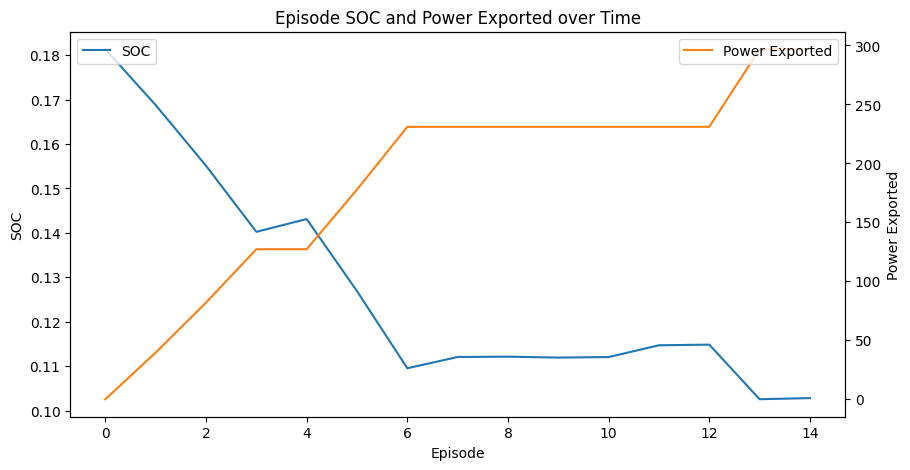

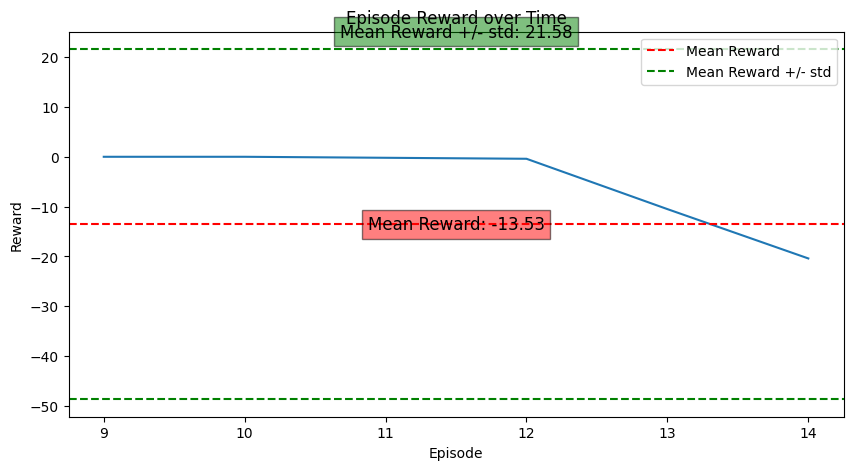

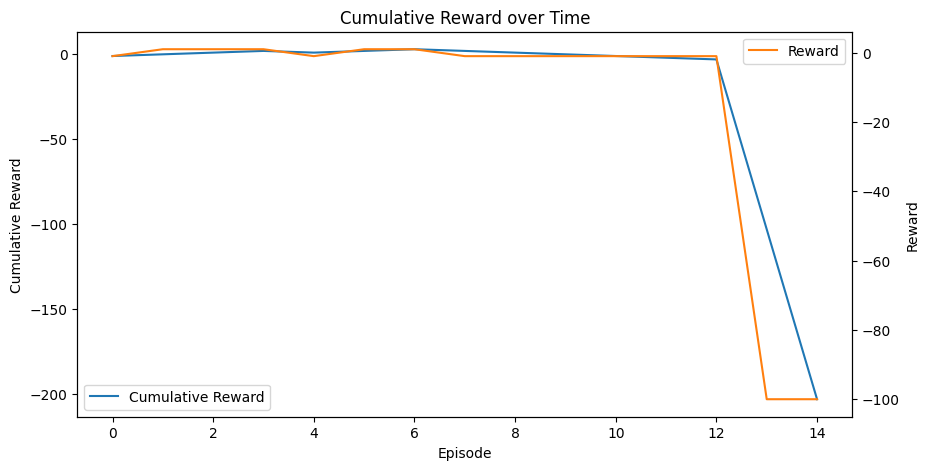

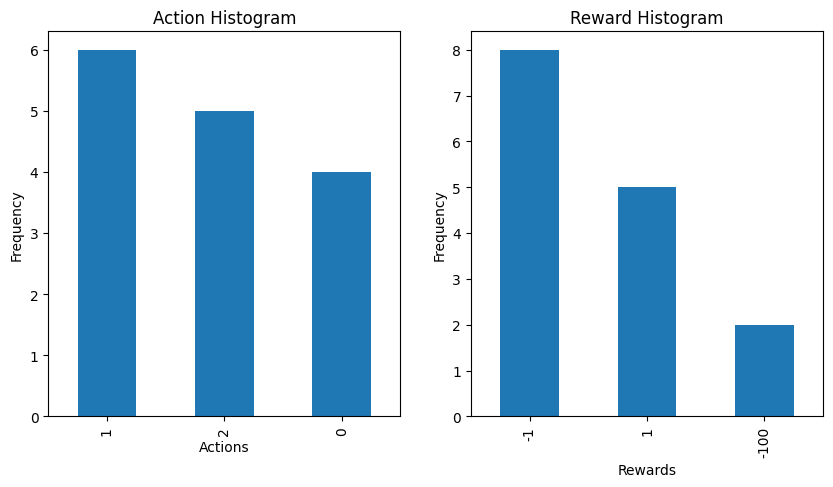

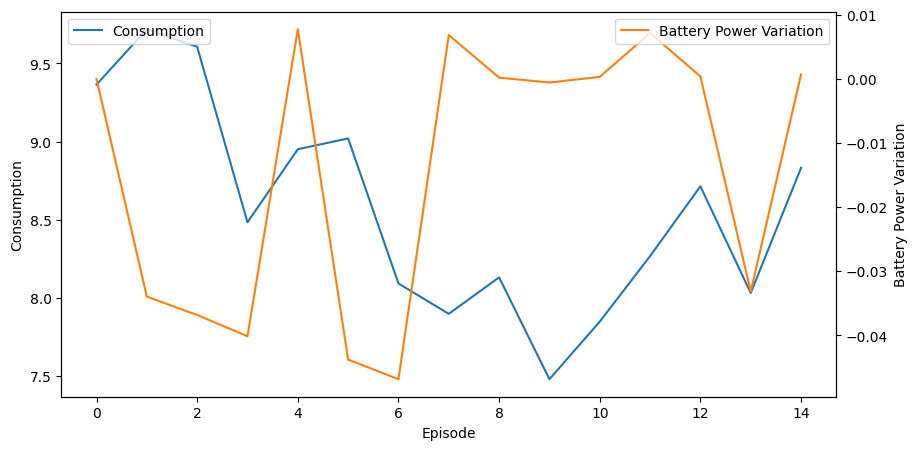

In [ ]:
simulate_episode(env)
env.close()

Ora implementiamo un agente basato su Q-learning per apprendere la strategia ottimale per la gestione della batteria.


In [ ]:
from stable_baselines3.common.env_checker import check_env

# Add Monitor wrapper to the environment
from stable_baselines3.common.monitor import Monitor

from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold, CallbackList

import time
import os

# Create log dir
log_dir = "logs/"
model_dir = "models/"
os.makedirs(log_dir, exist_ok=True)

# Create a folder with the current date and time
timestamp = time.strftime('%Y-%m-%d-%H-%M-%S', time.localtime())
log_dir = os.path.join(log_dir, timestamp)
model_dir = os.path.join(model_dir, timestamp)

os.makedirs(log_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

# Create the train environment
# Load the custom environment with the EnergyStorageEnv and check it
train_env = EnergyStorageEnv(consumer_id=0, window_size=window_size, target_window_size=target_window_size, seed=42)
check_env(train_env)
train_env = Monitor(train_env, log_dir+"/train/train", info_keywords=("Pi", "Pe", "soc", "prod", "cons", "prodf", "consf"))

# Create the evaluation environment
eval_env = EnergyStorageEnv(consumer_id=1, window_size=window_size, target_window_size=target_window_size, seed=42)
eval_env = Monitor(eval_env, log_dir+"/eval/eval", info_keywords=("Pi", "Pe", "soc", "prod", "cons", "prodf", "consf"))

# Create the test environment
test_env = EnergyStorageEnv(consumer_id=2, window_size=window_size, target_window_size=target_window_size, seed=42)
test_env = Monitor(test_env, log_dir+"/test/test", info_keywords=("Pi", "Pe", "soc", "prod", "cons", "prodf", "consf"))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/util.py:55: DeprecationWarning: jax.xla_computation is deprecated. Please use the AOT APIs; see https://jax.readthedocs.io/en/latest/aot.html. For example, replace xla_computation(f)(*xs) with jit(f).lower(*xs).compiler_ir('hlo'). See CHANGELOG.md for 0.4.30 for more examples.
  from jax import xla_computation as _xla_computation


In [ ]:
retrain = False
best_model_path = "models/best/best_model.zip"

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:

# Create the callback: check every 1000 steps
callback_on_best = StopTrainingOnRewardThreshold(reward_threshold=1000, verbose=0)
# Deterministic False to have a stochastic evaluation
# Cause we evaluate the agent with a different environment
# So we need to evaluate the robustness of the agent
eval_callback = EvalCallback(eval_env, callback_on_new_best=callback_on_best, eval_freq=10000, best_model_save_path=model_dir, deterministic=False, render=False, verbose=0, warn=False)

# Callback list to add the Monitor callback
callback_list = CallbackList([eval_callback])

# Define the DQN model
if retrain:
    model = DQN.load(
        path=best_model_path,
        env=train_env,
        verbose=0,
        learning_rate=1e-3,  # Learning rate
        buffer_size=50000,   # Size of the replay buffer
        learning_starts=50000, # Number of steps before training starts
        batch_size=32,       # Size of the batch sampled from the replay buffer
        target_update_interval=10000, # How often to update the target network
        train_freq=1000,        # Update the model every 4 steps
        gamma=0.99,          # Discount factor
        exploration_fraction=0.6,  # Fraction of total training time where exploration is applied
        exploration_initial_eps=1.0, # Initial value of epsilon for exploration
        exploration_final_eps=0.02, # Final value of epsilon after exploration
        tensorboard_log=log_dir+"/tensorlogs/" # Log directory
    )
else:
    model = DQN(
        "MultiInputPolicy",   # Use a MultiInputPolicy model
        train_env,           # Pass the environment
        learning_rate=1e-3,  # Learning rate
        buffer_size=50000,   # Size of the replay buffer
        learning_starts=50000, # Number of steps before training starts
        batch_size=32,       # Size of the batch sampled from the replay buffer
        target_update_interval=10000, # How often to update the target network
        train_freq=1000,        # Update the model every 4 steps
        gamma=0.99,          # Discount factor
        exploration_fraction=0.6,  # Fraction of total training time where exploration is applied
        exploration_initial_eps=1.0, # Initial value of epsilon for exploration
        exploration_final_eps=0.02, # Final value of epsilon after exploration
        verbose=0,            # Verbose mode to show progress
        tensorboard_log=log_dir+"/tensorlogs/" # Log directory
    )

# Train the DQN agent
model.learn(total_timesteps=10000, # 10000000
            progress_bar=True,
            callback=callback_list)  # Specify the number of timesteps

Output()

In [ ]:
del train_env
del eval_env

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Print the evaluation results
if retrain:
    model = DQN.load(model_dir+"/best_model.zip")

In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy

test_env.reset()
mean_reward, std_reward = evaluate_policy(model,
                                          test_env,
                                          n_eval_episodes=1, # 100
                                          deterministic=False)
print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

Mean reward: -175.00 +/- 0.00


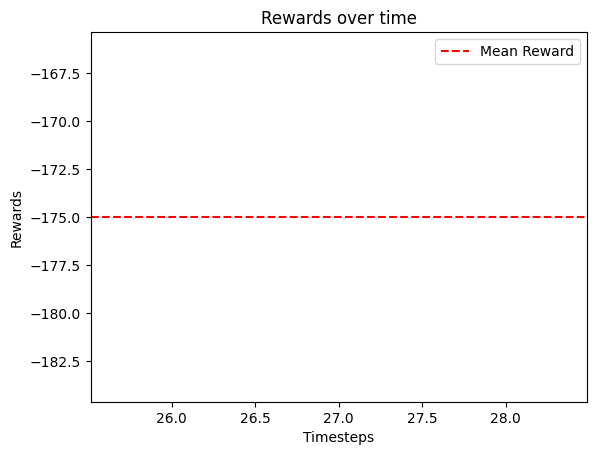

In [ ]:
# Plot the evaluation results
from stable_baselines3.common.results_plotter import load_results, ts2xy

results = load_results(log_dir+"/test/")
x, y = ts2xy(results, 'timesteps')

plt.plot(x, y)
plt.xlabel('Timesteps')
plt.ylabel('Rewards')
plt.title('Rewards over time')
plt.axhline(mean_reward, color='r', linestyle='--', label='Mean Reward')
plt.legend()
plt.show()

Prod forecast: [1.5905026] 
Consuption Forecasr: [1.5905026] 
SOC: [0.20260817]
Prod forecast: [1.6458932] 
Consuption Forecasr: [1.6458932] 
SOC: [0.20206401]
Prod forecast: [1.6846666] 
Consuption Forecasr: [1.6846666] 
SOC: [0.2015361]
Prod forecast: [1.7234402] 
Consuption Forecasr: [1.7234402] 
SOC: [0.20099983]
Prod forecast: [1.7519268] 
Consuption Forecasr: [1.7519268] 
SOC: [0.20044705]
Prod forecast: [1.7804134] 
Consuption Forecasr: [1.7804134] 
SOC: [0.1999298]
Prod forecast: [1.9038553] 
Consuption Forecasr: [1.9038553] 
SOC: [0.19935876]
Prod forecast: [2.0272973] 
Consuption Forecasr: [2.0272973] 
SOC: [0.19869329]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Prod forecast: [2.088227] 
Consuption Forecasr: [2.088227] 
SOC: [0.19804305]
Prod forecast: [2.1491568] 
Consuption Forecasr: [2.1491568] 
SOC: [0.19738445]
Prod forecast: [2.1966345] 
Consuption Forecasr: [2.1966345] 
SOC: [0.19669512]
Prod forecast: [2.244112] 
Consuption Forecasr: [2.244112] 
SOC: [0.19599107]
Prod forecast: [2.308207] 
Consuption Forecasr: [2.308207] 
SOC: [0.1952713]
Prod forecast: [2.3723018] 
Consuption Forecasr: [2.3723018] 
SOC: [0.19454111]
Prod forecast: [2.391293] 
Consuption Forecasr: [2.391293] 
SOC: [0.19378021]
Prod forecast: [2.410284] 
Consuption Forecasr: [2.410284] 
SOC: [0.1929777]
Prod forecast: [2.3264067] 
Consuption Forecasr: [2.3264067] 
SOC: [0.19220462]
Prod forecast: [2.2425296] 
Consuption Forecasr: [2.2425296] 
SOC: [0.19145389]
Prod forecast: [2.2045474] 
Consuption Forecasr: [2.2045474] 
SOC: [0.19073461]
Prod forecast: [2.1665652] 
Consuption Forecasr: [2.1665652] 
SOC: [0.1915747]
Prod forecast: [4.534119] 
Consuption Forecasr: [4.53

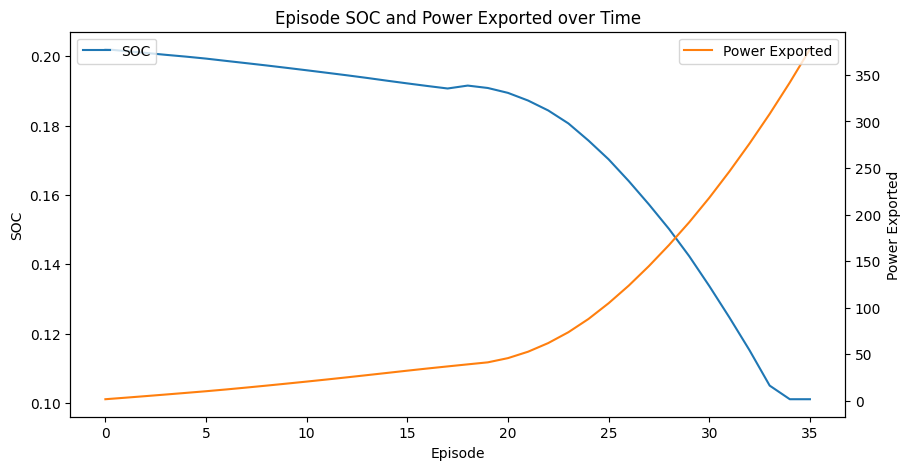

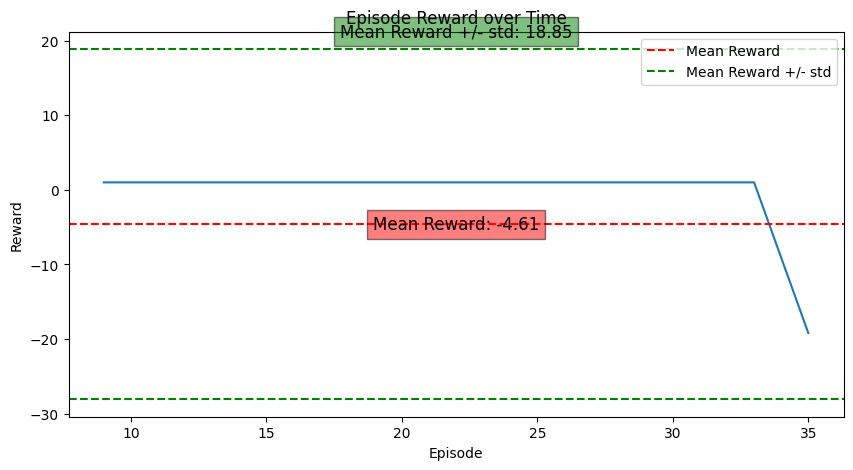

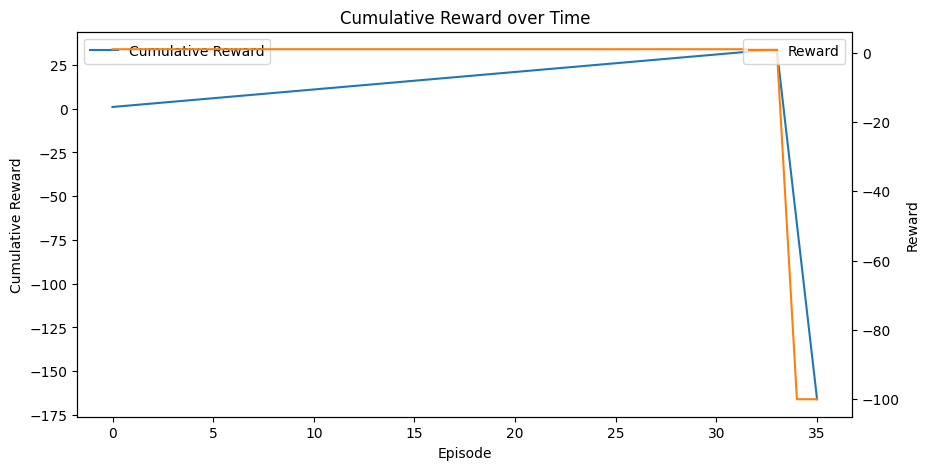

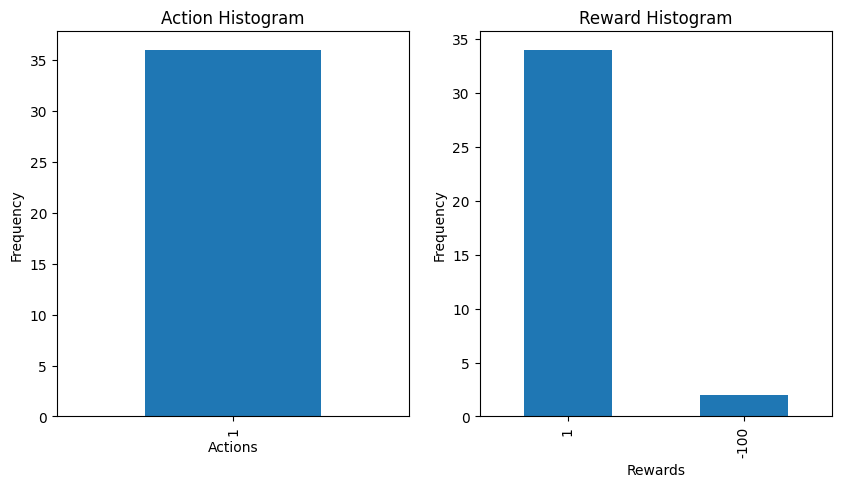

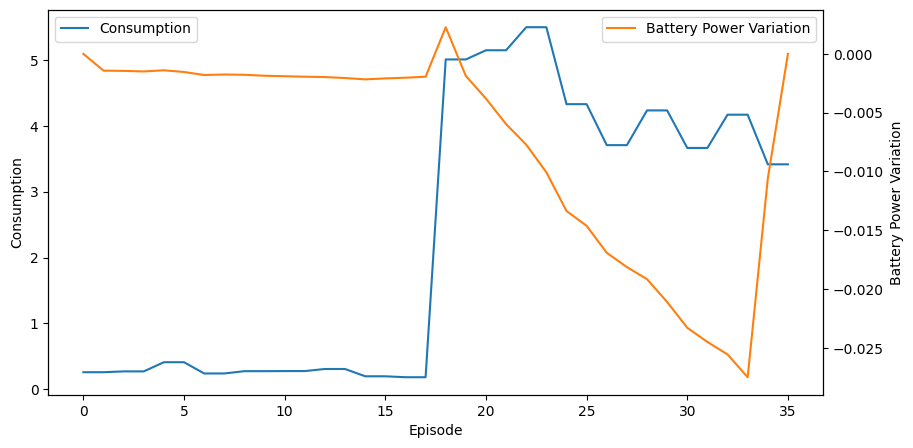

In [ ]:
Stats = namedtuple("Stats",["episode_lengths", "episode_rewards", "episode_power_imported", "episode_power_exported", "episode_soc", "episode_prod", "episode_cons", "episode_prodf", "episode_consf", "actions"])

# Evaluate the trained model
obs, _ = test_env.reset()

for i_episode in range(1):
    observation, _ = test_env.reset()
    print_observation(observation)
    done = False
    rewards = []
    power_imported = []
    power_exported = []
    soc = []
    prod = []
    cons = []
    actions = []
    while not done:
        # print_observation(observation)
        action, _states = model.predict(obs, deterministic=True)
        # print("Taking action: {}".format(action))
        observation, reward, done, _, extra_info =  test_env.step(action.take(0))
        print_observation(observation)
        rewards.append(reward)
        power_imported.append(extra_info["Pi"])
        power_exported.append(extra_info["Pe"])
        soc.append(extra_info["soc"])
        prod.append(extra_info["prod"])
        cons.append(extra_info["cons"])
        actions.append(action)

        if done:
            # print_observation(observation)
            #print("Game end. Reward: {}\n".format(float(reward)))
            Stats.episode_rewards = rewards
            Stats.episode_power_imported = power_imported
            Stats.episode_power_exported = power_exported
            Stats.episode_soc = soc
            Stats.episode_prod = prod
            Stats.episode_cons = cons
            Stats.actions = actions
            plot_episode_stats(Stats)
            break

In [ ]:
test_env.close()
del test_env

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Osservazioni
Dai primi esperimenti condotti emerge come l'agente predilige unicamente vendere costantemente l'energia immagazzinata arrivando infine alla conclusione dell'episodio in via prematura (power outage)(circa 200 step). Performando dunque nettamente peggio rispetto una policy completamente random in termini di lunghezza dell'episodio ma non in reward ottenuta.

Nota: l'environment viene inizializzato con una battery state of charge campionata da una  distribuzione uniforme tra socmin e socmax.

### Metrics

Tabella con le metriche da monitorare:


- `reward`: la reward ottenuta dall'agente
- `episode_length`: la lunghezza dell'episodio

| \ | Training | Validation |
|---------|-------------|----------------|
| `episode_mean_reward`| ![image info](imgs/exp_train_2024-09-12-10-02-21_mean_rew.png) | ![image info](imgs/exp_valid_2024-09-12-10-02-21_mean_rew.png) |
| `episode_mean_length` | ![image info](imgs/exp_train_2024-09-12-10-02-21_mean_len.png) | ![image info](imgs/exp_valid_2024-09-12-10-02-21_mean_len.png) |


  

## Considerazioni post revisione

All'inizio è corretto che l'agente venda energia senza curarsi di cosa accade, ma via via dovrebbe capire che se arriva al power outage è un grosso problema e cercare di evitarlo nelle iterazioni successive.

Una eventuale variazione può essere aggiungere fin da subito una reward che premi il nostro agente quando la batteria è intorno alla metà della sua carica, e che lo penalizzi quando la carica scende o sale troppo (nel primo caso perché sta esagerando nel vendere, nel secondo caso nel tenersi energia che potrebbe vendere). In questo modo, l'agente dovrebbe dare priorità alla conservazione della batteria.

Ad esempio:

> reward = - k ( soc - 40) (soc - 60)

può essere un tentativo, dove k è una costante positiva (un numero compreso tra 0 e 1, come 0.1, 0.5 o 1). Questo reward verrebbe dato in aggiunta a tutti quelli definito sopra.

Ovviamente la cosa importante nel RL è che:
nel tempo il nostro agente migliori la propria performance (quindi dovrebbe testarne il comportamento al crescere del numero di iterazioni di addestramento);
impari una policy che, non per forza all'inizio ma almeno dopo un po', sia migliore di quella random.

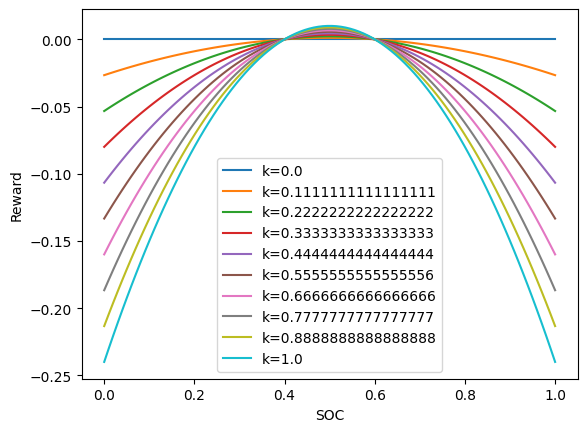

In [ ]:
# Definisci la funzione reward come -K(soc - 0.4)(soc - 0.6) e plotta la funzione con k variabile tra 0 e 1
import numpy as np
import matplotlib.pyplot as plt

def reward(soc, k):
    return - k*(soc - 0.4)*(soc - 0.6)

soc = np.linspace(0, 1, 100)
k = np.linspace(0, 1, 10)

fig, ax = plt.subplots()
for i in k:
    ax.plot(soc, reward(soc, i), label=f'k={i}')
ax.set_xlabel('SOC')
ax.set_ylabel('Reward')
ax.legend()
plt.show()


In [ ]:
from gymnasium import Wrapper
from stable_baselines3.common.env_checker import check_env

class NewRewardStrategyWrapper(Wrapper):
    def __init__(self, env):
        super(NewRewardStrategyWrapper, self).__init__(env)

    def step(self, action):
        # Week cycle counter
        self.weekcycle += 1

        obs, reward, done, _ , info = self.env.step(action)
        # Modifica il valore ritornato dalla funzione step
        soc = state[0]["soc"][0]

        reward = reward - 0.7 * (soc - 0.4) * (soc - 0.6)

        # Aggiungi un reward bonus ogni 96*7 step
        # Dunque ogni settimana
        if self.weekcycle % (96*7):
            reward += 3

        # Aggiungi un reward bonus ogni 96*30 step
        # Dunque ogni mese
        if self.weekcycle % (96*30):
            reward += 6

        return obs, float(reward), done, _ , info

    def reset(self, **kwargs):
        self.weekcycle = 0
        return self.env.reset(**kwargs)

# Utilizzo del wrapper
env = EnergyStorageEnv(consumer_id=1, window_size=window_size, target_window_size=target_window_size, seed=42)
wrapped_env = NewRewardStrategyWrapper(env)

# Esempio di utilizzo dell'ambiente wrappato
state = wrapped_env.reset()
print(state)
action = wrapped_env.action_space.sample()
print(action)
obs, reward, done, _ , info = wrapped_env.step(action)
print(f"Observation: {obs},\nReward: {reward},\nDone: {done},\nInfo: {info}")

check_env(wrapped_env)
env.close()
del env

({'prodf': array([22.68388], dtype=float32), 'consf': array([22.68388], dtype=float32), 'soc': array([0.78797734], dtype=float32)}, {})
2
Observation: {'prodf': array([24.063532], dtype=float32), 'consf': array([24.063532], dtype=float32), 'soc': array([0.78750813], dtype=float32)},
Reward: 7.9489483370245315,
Done: False,
Info: {'Pi': 0, 'Pe': 0, 'soc': 0.787508109997187, 'prod': 1.963498826580671, 'cons': 1.963498826580671, 'prodf': 24.063532483467103, 'consf': 24.063532483467103}


In [ ]:
from stable_baselines3.common.env_checker import check_env

# Add Monitor wrapper to the environment
from stable_baselines3.common.monitor import Monitor

from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold, CallbackList

import time
import os

# Create log dir
log_dir = "logs/"
model_dir = "models/"
os.makedirs(log_dir, exist_ok=True)

# Create a folder with the current date and time
timestamp = time.strftime('%Y-%m-%d-%H-%M-%S', time.localtime())
log_dir = os.path.join(log_dir, timestamp)
model_dir = os.path.join(model_dir, timestamp)

os.makedirs(log_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

# Create the train environment
# Load the custom environment with the EnergyStorageEnv and check it
train_env = EnergyStorageEnv(consumer_id=0, window_size=window_size, target_window_size=target_window_size, seed=42)
train_env = NewRewardStrategyWrapper(train_env)
train_env = Monitor(train_env, log_dir+"/train/train", info_keywords=("Pi", "Pe", "soc", "prod", "cons", "prodf", "consf"))
check_env(train_env)

# Create the evaluation environment
eval_env = EnergyStorageEnv(consumer_id=1, window_size=window_size, target_window_size=target_window_size, seed=42)
eval_env = NewRewardStrategyWrapper(eval_env)
eval_env = Monitor(eval_env, log_dir+"/eval/eval", info_keywords=("Pi", "Pe", "soc", "prod", "cons", "prodf", "consf"))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Create the callback: check every 1000 steps
callback_on_best = StopTrainingOnRewardThreshold(reward_threshold=500000, verbose=0)
# Deterministic False to have a stochastic evaluation
# Cause we evaluate the agent with a different environment
# So we need to evaluate the robustness of the agent
eval_callback = EvalCallback(eval_env,
                             callback_on_new_best=callback_on_best,
                             eval_freq=100000,
                             n_eval_episodes=5,
                             best_model_save_path=model_dir,
                             deterministic=False,
                             render=False, verbose=0, warn=False)

# Learning rate schedule
# A schedule takes the remaining progress as input and returns the learning rate
def learning_rate_schedule(progress):
    # Se manca ancora l'80% del training, il learning rate è 1e-5
    if (1-progress) <= 0.7:
        return 1e-5
    # Se manca ancora il 50% del training, il learning rate è 5e-4
    elif (1-progress) <= 0.9:
        return 5e-6
    # Altrimenti il learning rate è 1e-3
    else:
        return 1e-6

    # if progress < 0.5:
    #     return 1e-3
    # elif progress < 0.8:
    #     return 5e-4
    # else:
    #     return 1e-5

# Callback list to add the Monitor callback
callback_list = CallbackList([eval_callback])

# Define the DQN model
model = DQN(
    "MultiInputPolicy",   # Use a MultiInputPolicy model
    train_env,           # Pass the environment
    learning_rate=learning_rate_schedule,  # Learning rate
    buffer_size=900000,   # Size of the replay buffer
    learning_starts=500000, # Number of steps before training starts
    batch_size=32,       # Size of the batch sampled from the replay buffer
    target_update_interval=10000, # How often to update the target network
    train_freq=(15, "episode"), # 10000,        # Update the model every 4 steps
    gamma=0.7,          # Discount factor
    max_grad_norm=10,   # Max gradient norm
    exploration_fraction=0.6,  # Fraction of total training time where exploration is applied
    exploration_initial_eps=1.0, # Initial value of epsilon for exploration
    exploration_final_eps=0.02, # Final value of epsilon after exploration
    verbose=0,            # Verbose mode to show progress
    tensorboard_log=log_dir+"/tensorlogs/", # Log directory
    seed=42
)

# Train the DQN agent
model.learn(total_timesteps=15000000,
            progress_bar=True,
            callback=callback_list)  # Specify the number of timesteps

 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15,068,469/15,000,000  [ 5:45:55 < 0:00:00 , 839 it/s ]

In [ ]:
# Create the test environment
test_env = EnergyStorageEnv(consumer_id=2, window_size=window_size, target_window_size=target_window_size, seed=42)
test_env = NewRewardStrategyWrapper(test_env)
test_env = Monitor(test_env, log_dir+"/test/test",info_keywords=("Pi", "Pe", "soc", "prod", "cons", "prodf", "consf"))

In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy

test_env.reset()
mean_reward, std_reward = evaluate_policy(model, test_env, n_eval_episodes=50, deterministic=False)
print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Mean reward: 105646.50 +/- 66253.38


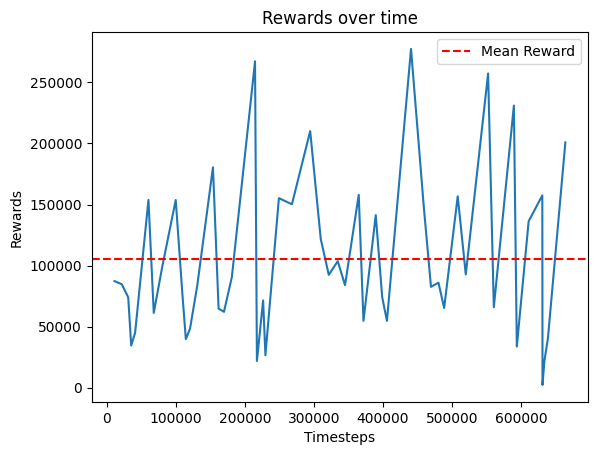

In [ ]:
# Plot the evaluation results
from stable_baselines3.common.results_plotter import load_results, ts2xy
import matplotlib.pyplot as plt

results = load_results(log_dir+"/test")
x, y = ts2xy(results, 'timesteps')

plt.plot(x, y)
plt.xlabel('Timesteps')
plt.ylabel('Rewards')
plt.title('Rewards over time')
plt.axhline(mean_reward, color='r', linestyle='--', label='Mean Reward')
plt.legend()
plt.show()

Prod forecast: [6.0470753] 
Consuption Forecasr: [6.0470753] 
SOC: [0.7514077]
Prod forecast: [6.2892113] 
Consuption Forecasr: [6.2892113] 
SOC: [0.7514077]
Prod forecast: [6.5313473] 
Consuption Forecasr: [6.5313473] 
SOC: [0.7512615]
Prod forecast: [6.545591] 
Consuption Forecasr: [6.545591] 
SOC: [0.7512615]
Prod forecast: [6.559834] 
Consuption Forecasr: [6.559834] 
SOC: [0.7512935]
Prod forecast: [5.4686384] 
Consuption Forecasr: [5.4686384] 
SOC: [0.7512935]
Prod forecast: [4.377443] 
Consuption Forecasr: [4.377443] 
SOC: [0.75140613]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Streaming output truncated to the last 5000 lines.
Consuption Forecasr: [2.4514313] 
SOC: [0.75129753]
Prod forecast: [2.4553878] 
Consuption Forecasr: [2.4553878] 
SOC: [0.75129753]
Prod forecast: [2.4593444] 
Consuption Forecasr: [2.4593444] 
SOC: [0.7512696]
Prod forecast: [2.3034592] 
Consuption Forecasr: [2.3034592] 
SOC: [0.7512696]
Prod forecast: [2.1475742] 
Consuption Forecasr: [2.1475742] 
SOC: [0.75280005]
Prod forecast: [4.442329] 
Consuption Forecasr: [4.442329] 
SOC: [0.75280005]
Prod forecast: [6.737084] 
Consuption Forecasr: [6.737084] 
SOC: [0.7528031]
Prod forecast: [9.038169] 
Consuption Forecasr: [9.038169] 
SOC: [0.7528031]
Prod forecast: [11.339254] 
Consuption Forecasr: [11.339254] 
SOC: [0.7528513]
Prod forecast: [13.749538] 
Consuption Forecasr: [13.749538] 
SOC: [0.7528513]
Prod forecast: [16.159822] 
Consuption Forecasr: [16.159822] 
SOC: [0.7523036]
Prod forecast: [17.701265] 
Consuption Forecasr: [17.701265] 
SOC: [0.7523036]
Prod forecast: [19.242706] 
Con

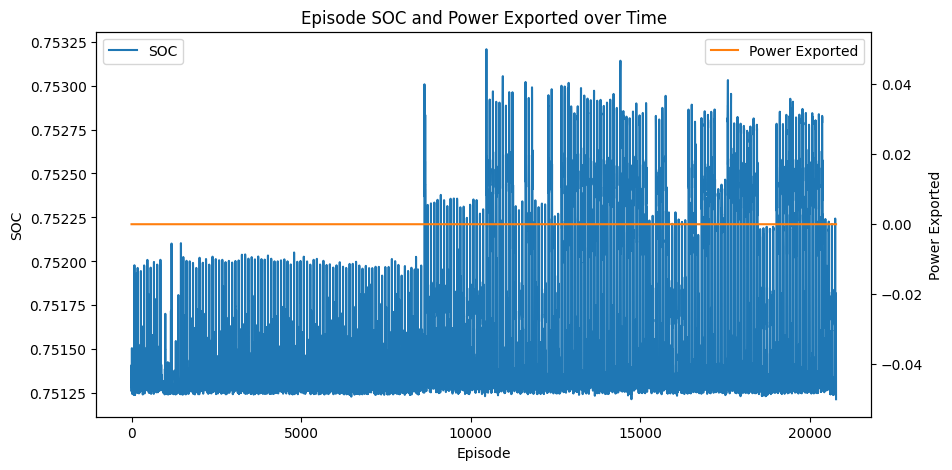

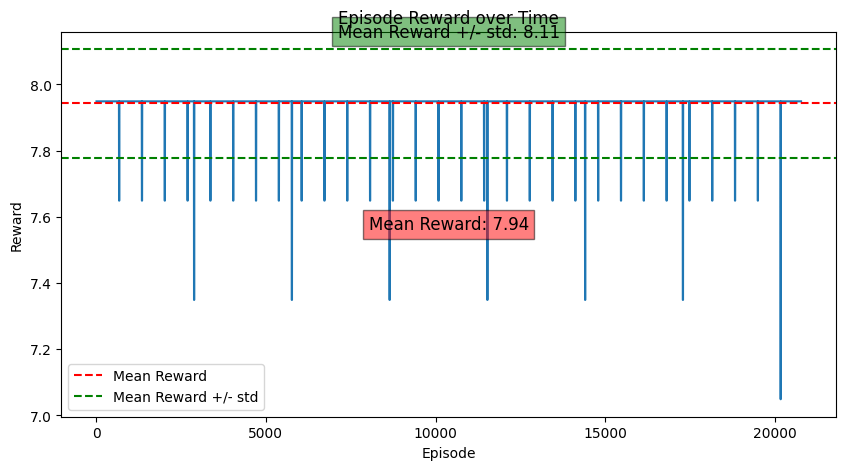

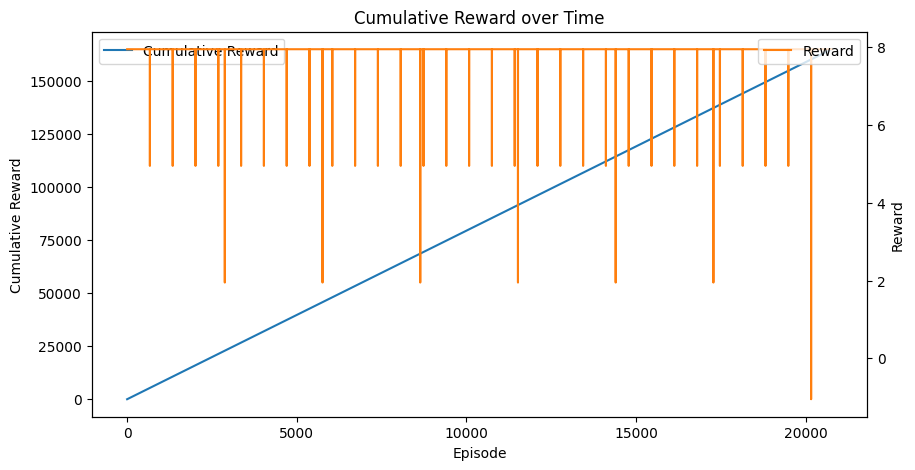

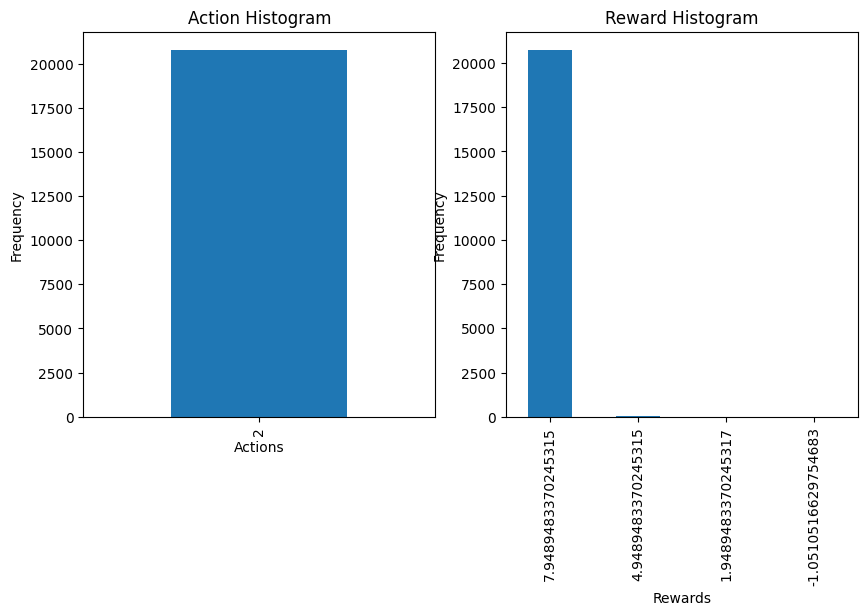

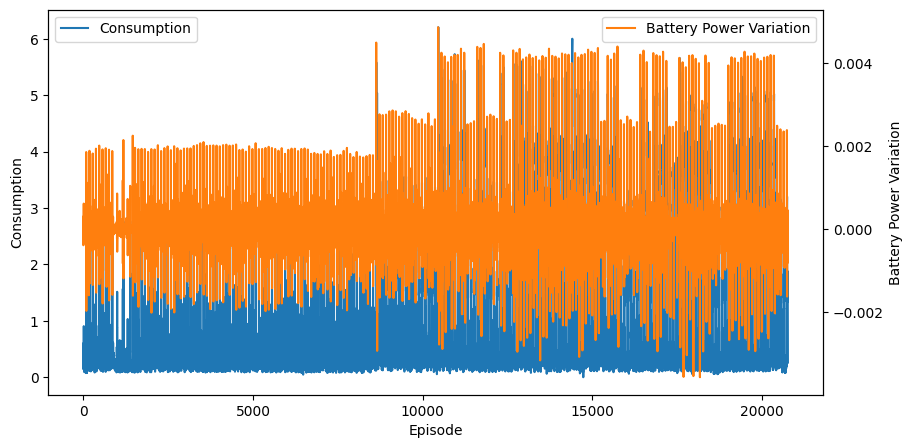

In [ ]:
Stats = namedtuple("Stats",["episode_lengths", "episode_rewards", "episode_power_imported", "episode_power_exported", "episode_soc", "episode_prod", "episode_cons", "episode_prodf", "episode_consf", "actions"])

# Evaluate the trained model
obs, _ = test_env.reset()

for i_episode in range(1):
    observation, _ = test_env.reset()
    print_observation(observation)
    done = False
    rewards = []
    power_imported = []
    power_exported = []
    soc = []
    prod = []
    cons = []
    actions = []
    while not done:
        # print_observation(observation)
        action, _states = model.predict(obs, deterministic=True)
        # print("Taking action: {}".format(action))
        observation, reward, done, _, extra_info =  test_env.step(action.take(0))
        print_observation(observation)
        rewards.append(reward)
        power_imported.append(extra_info["Pi"])
        power_exported.append(extra_info["Pe"])
        soc.append(extra_info["soc"])
        prod.append(extra_info["prod"])
        cons.append(extra_info["cons"])
        actions.append(action)

        if done:
            # print_observation(observation)
            #print("Game end. Reward: {}\n".format(float(reward)))
            Stats.episode_rewards = rewards
            Stats.episode_power_imported = power_imported
            Stats.episode_power_exported = power_exported
            Stats.episode_soc = soc
            Stats.episode_prod = prod
            Stats.episode_cons = cons
            Stats.actions = actions
            plot_episode_stats(Stats)
            break

## Osservazioni
Dai primi esperimenti condotti emerge come l'agente predilige unicamente vendere costantemente l'energia immagazzinata arrivando infine alla conclusione dell'episodio in via prematura (power outage)(circa 200 step). Performando dunque nettamente peggio rispetto una policy completamente random in termini di lunghezza dell'episodio ma non in reward ottenuta.

Nota: l'environment viene inizializzato con una battery state of charge campionata da una  distribuzione uniforme tra socmin e socmax.

### Metrics

Tabella con le metriche da monitorare:


- `reward`: la reward ottenuta dall'agente
- `episode_length`: la lunghezza dell'episodio

| \ | Training | Validation |
|---------|-------------|----------------|
| `episode_mean_reward`| ![image info](imgs/exp_train_2024-09-12-10-02-21_mean_rew.png) | ![image info](imgs/exp_valid_2024-09-12-10-02-21_mean_rew.png) |
| `episode_mean_length` | ![image info](imgs/exp_train_2024-09-12-10-02-21_mean_len.png) | ![image info](imgs/exp_valid_2024-09-12-10-02-21_mean_len.png) |


In [ ]:
!pip install pyppeteer


In [ ]:
from pyppeteer import launch
import asyncio


In [ ]:
async def generate_pdf(notebook_path, pdf_path):
       browser = await launch(handleSIGINT=False, handleSIGTERM=False, handleSIGHUP=False)
       page = await browser.newPage()
       await page.goto(f'http://localhost:9000/notebooks/{notebook_path}')
       await page.pdf({'path': pdf_path, 'format': 'A4'})
       await browser.close()

In [ ]:
!pip install nest_asyncio
!ls


In [ ]:
import asyncio
import nest_asyncio
import nbformat
from nbconvert import HTMLExporter
from pyppeteer import launch

# Applica nest_asyncio per evitare problemi con l'event loop
nest_asyncio.apply()

async def generate_pdf(notebook_path, pdf_path):
    # Leggi il notebook
    with open(notebook_path, 'r', encoding='utf-8') as f:
        notebook_content = nbformat.read(f, as_version=4)

    # Converti il notebook in HTML
    html_exporter = HTMLExporter()
    body, _ = html_exporter.from_notebook_node(notebook_content)

    # Scrivi il contenuto HTML temporaneamente
    temp_html_path = 'temp_notebook.html'
    with open(temp_html_path, 'w', encoding='utf-8') as f:
        f.write(body)

    # Usa Pyppeteer per generare il PDF
    browser = await launch(headless=True, args=['--no-sandbox'])
    page = await browser.newPage()
    await page.goto(f'file://{temp_html_path}')  # Carica il file HTML
    await page.pdf({'path': pdf_path, 'format': 'A4'})  # Genera il PDF
    await browser.close()
    print(f"PDF generato: {pdf_path}")

# Percorso del notebook e PDF di output
notebook_path = 'experiment.ipynb'  # Sostituisci con il percorso corretto
pdf_path = 'experiment.pdf'

# Esegui la funzione di conversione
await generate_pdf(notebook_path, pdf_path)


In [ ]:
notebook_path = 'experiment.ipynb'
   pdf_path = 'nome_del_tuo_pdf.pdf'
   asyncio.get_event_loop().run_until_complete(generate_pdf(notebook_path, pdf_path))

In [ ]:
!jupyter nbconvert --to pdf /content/experiment.ipynb